In [1]:
using Gen, Distributions
using StatsPlots
using StatsBase
using DataFrames

┌ Info: Precompiling Gen [ea4f424c-a589-11e8-07c0-fd5c91b9da4a]
└ @ Base loading.jl:1423
┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1423


## Agent Simulation

In [2]:
food = [1,2,3]

3-element Vector{Int64}:
 1
 2
 3

In [3]:
distance = [10, 3, 15]

3-element Vector{Int64}:
 10
  3
 15

In [4]:
waiting_time = [2.,5.5,1.]

3-element Vector{Float64}:
 2.0
 5.5
 1.0

In [5]:
preference = [0.7, 1.1, 1.3]

3-element Vector{Float64}:
 0.7
 1.1
 1.3

In [6]:
restaurant_visits = zeros(3)

3-element Vector{Float64}:
 0.0
 0.0
 0.0

In [7]:
@gen function easy_agent_datasource()
    favourite_food ~ categorical([1/3, 1/3, 1/3])
    distance ~ categorical([1/3, 1/3, 1/3])
    waittime ~ categorical([1/3, 1/3, 1/3])
    return mode((favourite_food, distance, waittime))
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[], false, Union{Nothing, Some{Any}}[], var"##easy_agent_datasource#291", Bool[], false)

In [8]:
easy_agent_datasource(),easy_agent_datasource(),easy_agent_datasource()

(2, 2, 2)

In [9]:
waittimes = DataFrame(Restaurant=[:A,:B, :A,:A,:C,:C], Waittime=[2., 5.5,2.2, 2.1, 1., 1.])

,Restaurant,Waittime
,Symbol,Float64
1,A,2.0
2,B,5.5
3,A,2.2
4,A,2.1
5,C,1.0
6,C,1.0


In [10]:
@gen function waittime_model(visits)
    w_bar ~ gamma(2, 1)
    w_i = Dict()
    w_i[:A] = {(:w_i, :A)} ~ gamma(w_bar, 1)
    w_i[:B] = {(:w_i, :B)} ~ gamma(w_bar, 1)
    w_i[:C] = {(:w_i, :C)} ~ gamma(w_bar, 1)
    
    
    waittimes = Vector{Float64}(undef,length(visits))
    for (i,v) in enumerate(visits)
       waittimes[i] = {(:waittime,i)} ~ gamma(w_i[v], 1)
    end
    return waittimes
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any], false, Union{Nothing, Some{Any}}[nothing], var"##waittime_model#292", Bool[0], false)

In [11]:
waittime_model(waittimes.Restaurant)

6-element Vector{Float64}:
 0.016154772603595345
 1.062871518060831
 1.5151349614962268e-5
 0.5491720360608622
 0.048299144184275875
 0.3081142913508835

In [12]:
observations = Gen.choicemap()

for (i,w) in enumerate(waittimes.Waittime)
    observations[(:waittime,i)] = w
end

traces = [importance_resampling(waittime_model, (waittimes.Restaurant,), observations, 100)[1] for _ in 1:100]

100-element Vector{Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}}:
 Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any], false, Union{Nothing, Some{Any}}[nothing], var"##waittime_model#292", Bool[0], false), Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}((:w_i, :A) => Gen.ChoiceOrCallRecord{Float64}(3.8016612036137913, -2.750883270848607, NaN, true), (:w_i, :B) => Gen.ChoiceOrCallRecord{Float64}(2.5009371589911087, -1.7508407566216444, NaN, true), (:w_i, :C) => Gen.ChoiceOrCallRecord{Float64}(2.316927076860748, -1.6217034404108275, NaN, true), (:waittime, 3) => Gen.ChoiceOrCallRecord{Float64}(2.2, -1.539321833581779, NaN, true), (:waittime, 4) => Gen.ChoiceOrCallRecord{Float64}(2.1, -1.5696551565775654, NaN, true), (:waittime, 6) => Gen.ChoiceOrCallRecord{Float64}(1.0, -1.1644238697735712, NaN, true), :w_bar => Gen.ChoiceOrCallRecord{Float64}(1.718006686519606, -1.176841970928093, NaN, true), (:wai

In [13]:
function get_waittimes(traces)
    choices = Gen.get_choices.(traces)
    w_bars = Gen.get_value.(choices, :w_bar)
    w_is = Dict()
    w_is[:A] = Vector{Float64}(undef, length(choices))
    w_is[:B] = Vector{Float64}(undef, length(choices))
    w_is[:C] = Vector{Float64}(undef, length(choices))
    for (i,choice) in enumerate(choices)
        w_is[:A][i] = Gen.get_value(choice, (:w_i,:A))
        w_is[:B][i] = Gen.get_value(choice, (:w_i,:B))
        w_is[:C][i] = Gen.get_value(choice, (:w_i,:C))
    end
    w_bars_m, w_bars_std = mean_and_std(w_bars)
    w_A_is_m, w_A_is_std = mean_and_std(w_is[:A])
    w_B_is_m, w_B_is_std = mean_and_std(w_is[:B])
    w_C_is_m, w_C_is_std = mean_and_std(w_is[:C])

    return (w_bars_m,w_bars_std),(w_A_is_m, w_A_is_std),(w_B_is_m, w_B_is_std),(w_C_is_m, w_C_is_std)
end

get_waittimes (generic function with 1 method)

In [14]:
(w_bars_m,w_bars_std),(w_A_is_m, w_A_is_std),(w_B_is_m, w_B_is_std),(w_C_is_m, w_C_is_std) = get_waittimes(traces)

((2.680319761796484, 0.8900299574294306), (2.4870839498299535, 0.7489428310111138), (3.9805151261210345, 1.7435291693827406), (1.655215748228114, 0.5985782082633068))

In [15]:
w_bars = []
for i in 1:size(waittimes,1)  

    observations = Gen.choicemap()

    for (j,w) in enumerate(waittimes[1:i,:].Waittime)
        observations[(:waittime,j)] = w
    end

    traces = [importance_resampling(waittime_model, (waittimes[1:i,:].Restaurant,), observations, 100)[1] for _ in 1:100]
    @info get_waittimes(traces)
end

┌ Info: ((2.3697034713935405, 1.1179866397885039), (2.4785827017591786, 1.1032303650234867), (2.373986242894531, 1.964658381777601), (2.3507687827462806, 1.870700110323317))
└ @ Main In[15]:11
┌ Info: ((2.9870250415963278, 1.1127570808367901), (2.7063828297278354, 1.0903213022736291), (4.103258689669664, 1.473161860599855), (3.092078528814611, 2.1866193476381564))
└ @ Main In[15]:11
┌ Info: ((3.0983686502063756, 1.1590892316115977), (2.6141206604012206, 0.9106395397411727), (4.3844563596302315, 1.6731369171430288), (2.958867137927304, 2.0952226587162115))
└ @ Main In[15]:11
┌ Info: ((3.0622145869243784, 1.1296020116777254), (2.5743769525674396, 0.7894216864765191), (4.1839777526478095, 1.686360351676973), (3.094899722729876, 1.8359890784078787))
└ @ Main In[15]:11
┌ Info: ((2.727222769599997, 0.9539963907141905), (2.601212043058037, 0.7875651961257847), (3.83444691361199, 1.7850654618938087), (1.7564275410149799, 0.8643314162418722))
└ @ Main In[15]:11
┌ Info: ((2.656024218009606, 1.01

In [16]:
waiting_time = (w_A_is_m, w_B_is_m, w_C_is_m)

(2.4870839498299535, 3.9805151261210345, 1.655215748228114)

In [17]:
@gen function complex_agent_datasource(waittime)
    feeling_random ~ bernoulli(0.5)
    if feeling_random
        choice ~ categorical([1/3, 1/3, 1/3])
        return choice
    end
    gusto ~ categorical([1/3, 1/3, 1/3])
    temperature ~ normal(0,5)
    distance_bias = distance .* temperature
    hurry ~ bernoulli(0.9)
    time_bias = waittime .* hurry
    
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any], false, Union{Nothing, Some{Any}}[nothing], var"##complex_agent_datasource#293", Bool[0], false)

In [18]:
@gen function alternative_agent_datasource(waittime)
    un_probs = exp.((.- waittime ./ sum(waittime)) .+ (.- distance ./ sum(distance)) .+ preference ./ sum(preference))
    probs = un_probs ./ sum(un_probs)
    choice ~ categorical(probs)
    return choice
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any], false, Union{Nothing, Some{Any}}[nothing], var"##alternative_agent_datasource#294", Bool[0], false)

In [19]:
alternative_agent_datasource(waiting_time),alternative_agent_datasource(waiting_time),alternative_agent_datasource(waiting_time)

(2, 3, 3)

In [20]:
data_vector = [alternative_agent_datasource(waiting_time) for _ in 1:140]

140-element Vector{Int64}:
 1
 1
 3
 3
 1
 2
 3
 2
 3
 2
 3
 2
 2
 ⋮
 2
 3
 3
 2
 3
 3
 1
 2
 2
 3
 2
 2

In [21]:
data = DataFrame(RestaurantChoice=data_vector)

,RestaurantChoice
,Int64
1,1
2,1
3,3
4,3
5,1
6,2
7,3
8,2
9,3


In [22]:
include("../inverse-planning/geometric_primitives.jl");
include("../inverse-planning/scene.jl");
include("../inverse-planning/planning.jl");
include("../inverse-planning/viz.jl");

In [23]:
scene = Scene(xmin=0, xmax=1, ymin=0, ymax=1)
add_obstacle!(scene, make_square(Point(0.30, 0.20), 0.1))
add_obstacle!(scene, make_square(Point(0.83, 0.80), 0.1))
add_obstacle!(scene, make_square(Point(0.80, 0.40), 0.1))
#add_obstacle!(scene, make_square(Point(0.50, 0.09), 0.05))
#add_obstacle!(scene, make_square(Point(0.10, 0.50), 0.05))
horizontal = false
vertical = true
wall_thickness = 0.02
add_obstacle!(scene, make_line(horizontal, Point(0.20, 0.40), 0.40, wall_thickness))
add_obstacle!(scene, make_line(vertical, Point(0.60, 0.40), 0.40, wall_thickness))
add_obstacle!(scene, make_line(horizontal, Point(0.60 - 0.15, 0.80), 0.15 + wall_thickness, wall_thickness))
add_obstacle!(scene, make_line(horizontal, Point(0.20, 0.80), 0.15, wall_thickness))
add_obstacle!(scene, make_line(vertical, Point(0.20, 0.40), 0.40, wall_thickness));
add_obstacle!(scene, make_line(vertical, Point(0.50,0.0), 0.30, wall_thickness));
add_obstacle!(scene, make_line(horizontal, Point(0.00,0.5), 0.20, wall_thickness));

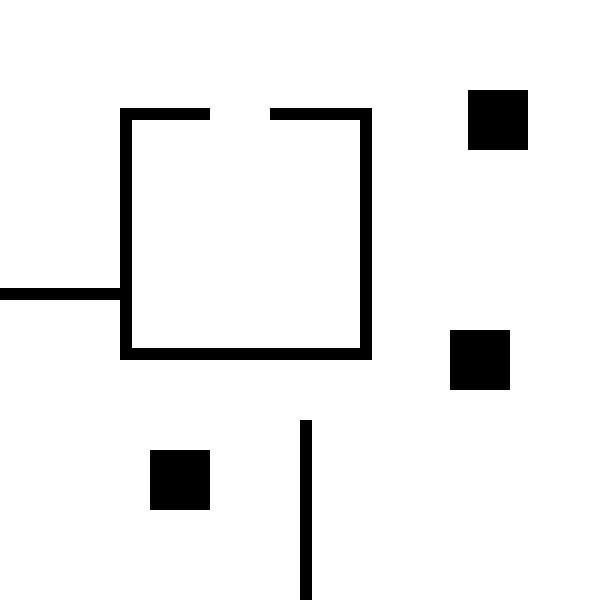

In [24]:
# We visualize the scene below.
visualize() do
    draw_scene(scene)
end

In [25]:
start = Point(0.1, 0.1)
dest = Point(0.5, 0.5)
planner_params = PlannerParams(rrt_iters=600, rrt_dt=3.0,
                               refine_iters=3500, refine_std=1.)
example_path1 = plan_path(start, dest, scene, planner_params)
example_path2 = plan_path(start, dest, scene, planner_params)
example_path3 = plan_path(start, dest, scene, planner_params)

Path(Point[Point(0.1, 0.1), Point(0.22289382395700352, 0.2697118386124752), Point(0.5027833412716888, 0.3282709671710743), Point(0.64519210744407, 0.2869325871546076), Point(0.9001533127774747, 0.3305538232716552), Point(0.9244268874855067, 0.8410492691917162), Point(0.9356876108515738, 0.9546444472020239), Point(0.7045868954677483, 0.908023593441116), Point(0.47177914065967, 0.88332672315909), Point(0.3960950525867174, 0.8009120081608843), Point(0.45075181840850687, 0.598552659315946), Point(0.5, 0.5)])

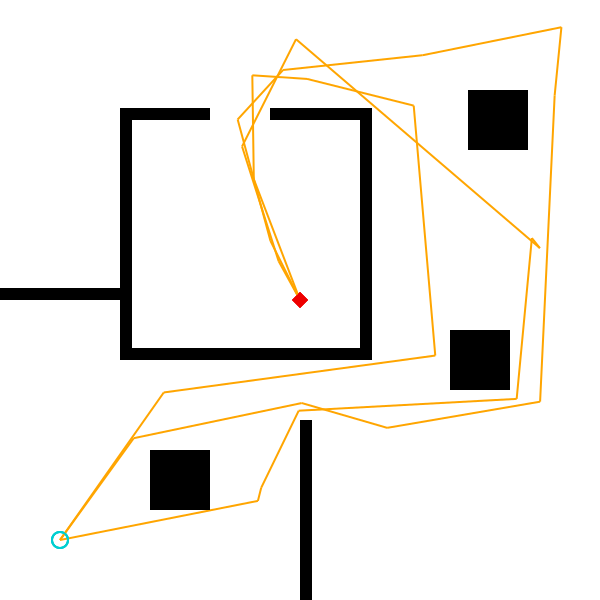

In [26]:
visualize() do
    draw_trace(Dict(:start => start,
                    :dest => dest,
                    :scene => scene,
                    :path => example_path1.points);
               should_draw_measurements=false)
        draw_trace(Dict(:start => start,
                    :dest => dest,
                    :scene => scene,
                    :path => example_path2.points);
               should_draw_measurements=false)
        draw_trace(Dict(:start => start,
                    :dest => dest,
                    :scene => scene,
                    :path => example_path3.points);
               should_draw_measurements=false)
end

In [27]:
speed = 1.
dt = 0.1
num_ticks = 10;
example_locations = walk_path(example_path1, speed, dt, num_ticks)
println(example_locations)

Point[Point(0.1, 0.1), Point(0.19810110966586675, 0.11939516131218267), Point(0.2962022193317335, 0.13879032262436533), Point(0.3943033289976003, 0.158185483936548), Point(0.4533777423673525, 0.22414172734350826), Point(0.4971462902726284, 0.314054541859925), Point(0.5960954389657336, 0.32083475683183893), Point(0.6959485376850532, 0.32625312154361386), Point(0.7958016364043727, 0.33167148625538884), Point(0.8643618463096613, 0.36966312881260954)]


In [28]:
@gen function walk_model(
        scene::Scene, dt::Float64, num_ticks::Int, 
        planner_params::PlannerParams)

    # sample the start point of the agent from the prior
    start_x ~ uniform(0, 1)
    start_y ~ uniform(0, 1)
    start = Point(start_x, start_y)

    # sample the destination point of the agent from the prior
    dest_x ~ uniform(0, 1)
    dest_y ~ uniform(0, 1)
    dest = Point(dest_x, dest_y)

    # plan a path that avoids obstacles in the scene
    maybe_path = plan_path(start, dest, scene, planner_params)
    planning_failed = maybe_path === nothing
    
    # sample the speed from the prior
    speed ~ uniform(0.3, 1)

    if planning_failed   
        # path planning failed; assume agent stays at start location indefinitely
        locations = fill(start, num_ticks)
    else   
        # path planning succeeded; move along the path at constant speed
        locations = walk_path(maybe_path, speed, dt, num_ticks)
    end

    # generate noisy measurements of the agent's location at each time point
    noise = 0.02
    for (i, point) in enumerate(locations)
        x = {:meas => (i, :x)} ~ normal(point.x, noise)
        y = {:meas => (i, :y)} ~ normal(point.y, noise)
    end

    return (planning_failed, maybe_path)
end;

In [29]:
@gen function chase_model(
        scene::Scene, dt::Float64, num_ticks::Int, 
        planner_params::PlannerParams)

    # sample the start point of the agent from the prior
    start_x ~ uniform(0, 1)
    start_y ~ uniform(0, 1)
    start = Point(start_x, start_y)

    # sample the destination point of the agent from the prior
    restaurant ~ categorical([1/2, 1/2])
    dest_x ~ normal(max(0.1, min(0.9, restaurant - 1)), 0.05)
    dest_y ~ normal(max(0.1, min(0.9, 2 - restaurant)), 0.05)
    dest = Point(dest_x, dest_y)

    # plan a path that avoids obstacles in the scene
    maybe_path = plan_path(start, dest, scene, planner_params)
    planning_failed = maybe_path === nothing
    
    # sample the speed from the prior
    speed ~ uniform(0.3, 1)

    if planning_failed   
        # path planning failed; assume agent stays at start location indefinitely
        locations = fill(start, num_ticks)
    else   
        # path planning succeeded; move along the path at constant speed
        locations = walk_path(maybe_path, speed, dt, num_ticks)
    end

    # generate noisy measurements of the agent's location at each time point
    noise = 0.02
    for (i, point) in enumerate(locations)
        x = {:meas => (i, :x)} ~ normal(point.x, noise)
        y = {:meas => (i, :y)} ~ normal(point.y, noise)
    end

    return (planning_failed, maybe_path)
end;

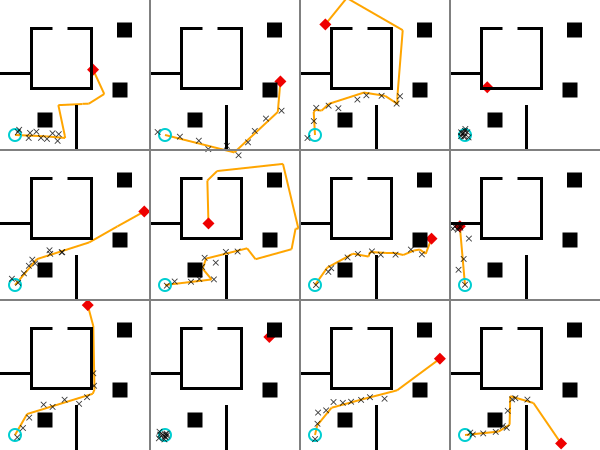

In [30]:
# Let's visualize several traces of the function, with the start location fixed to
# a point in the lower-left corner:
constraints = Gen.choicemap()
constraints[:start_x] = 0.1
constraints[:start_y] = 0.1

traces = [Gen.generate(
    walk_model, (scene, dt, num_ticks, planner_params), constraints
    )[1] for i in 1:12];
visualize_grid(traces, 4, 600; separators="gray") do trace, frame
    draw_trace(trace, frame; draw_measurements=true, markersize=6)
end

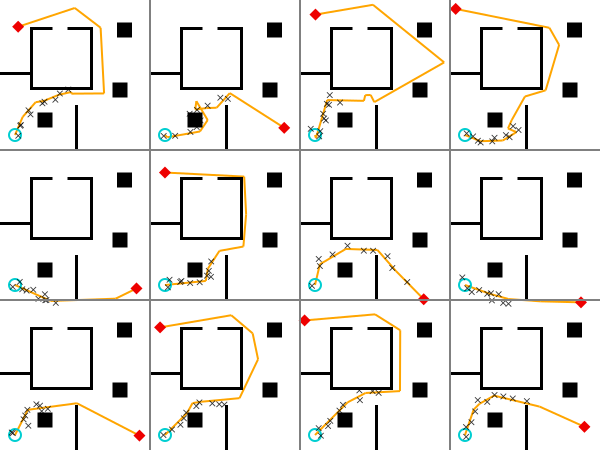

In [31]:
# Let's visualize several traces of the function, with the start location fixed to
# a point in the lower-left corner:
constraints = Gen.choicemap()
constraints[:start_x] = 0.1
constraints[:start_y] = 0.1

traces = [Gen.generate(
    chase_model, (scene, dt, num_ticks, planner_params), constraints
    )[1] for i in 1:12];
visualize_grid(traces, 4, 600; separators="gray") do trace, frame
    draw_trace(trace, frame; draw_measurements=true, markersize=6)
end

In [32]:
measurements = [
    Point(0.0980245, 0.104775),
    Point(0.113734, 0.150773),
    Point(0.100412, 0.195499),
    Point(0.114794, 0.237386),
    Point(0.0957668, 0.277711),
    Point(0.140181, 0.31304),
    Point(0.124384, 0.356242),
    Point(0.122272, 0.414463),
    Point(0.124597, 0.462056),
    Point(0.126227, 0.498338)];

In [33]:
function do_inference(
        scene::Scene, dt::Float64, num_ticks::Int, 
        planner_params::PlannerParams, 
        start::Point, measurements::Vector{Point}, amount_of_computation::Int, model=walk_model)
    
    # Constrain the observed measurements.
    observations = Gen.choicemap()
    observations[:start_x] = start.x
    observations[:start_y] = start.y
    for (i, m) in enumerate(measurements)
        observations[:meas => (i, :x)] = m.x
        observations[:meas => (i, :y)] = m.y
    end
    
    trace, = importance_resampling(model, (scene, dt, num_ticks, planner_params), observations, amount_of_computation)
    
    return trace
end;

In [34]:
function visualize_inference(measurements, scene, start; computation_amt=50, samples=1000, num_ticks=num_ticks, draw_measurements=true, draw_path=false, statistics=false, restaurant_visits=zeros(3), model=walk_model)
    if statistics
        restaurant_visits .= 0
    end
    visualize() do
        for i in 1:samples
            trace = do_inference(scene, dt, num_ticks, planner_params, start, measurements, computation_amt, model)
            draw_trace(trace; draw_measurements=draw_measurements, draw_path=draw_path)
            if statistics && Gen.has_value(Gen.get_choices(trace), :restaurant)
                restaurant_visits[trace[:restaurant]] += 1
            end
        end
    end
end;

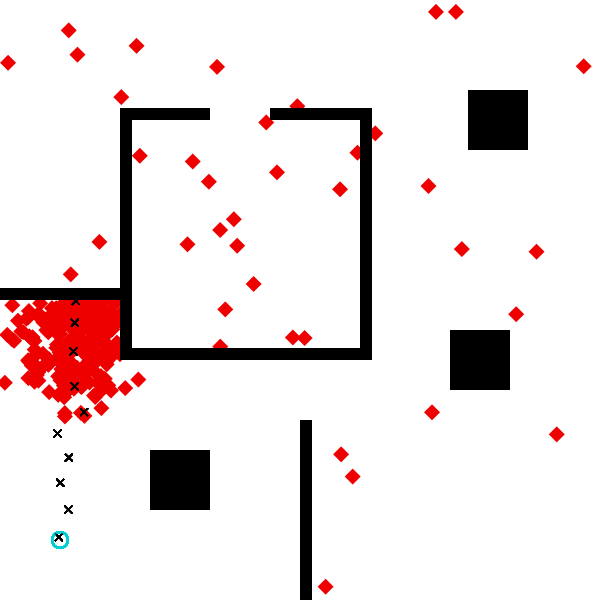

In [35]:
visualize_inference(
    measurements, scene, start, computation_amt=100, samples=250, model=walk_model)

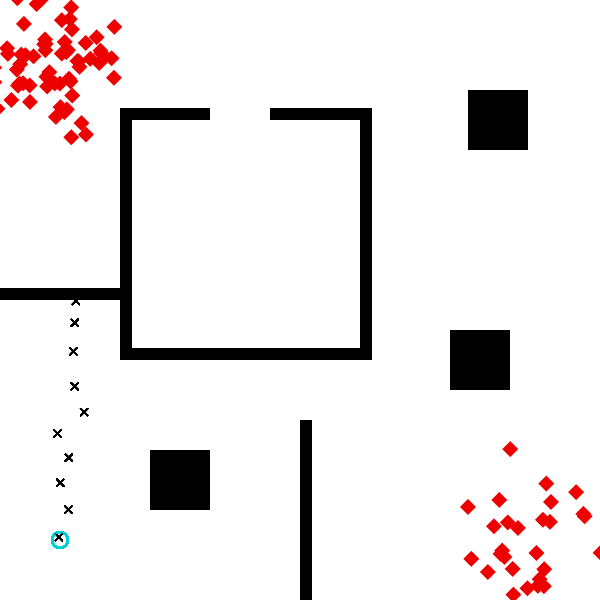

In [36]:
visualize_inference(
    measurements, scene, start, computation_amt=70, samples=100, model=chase_model)

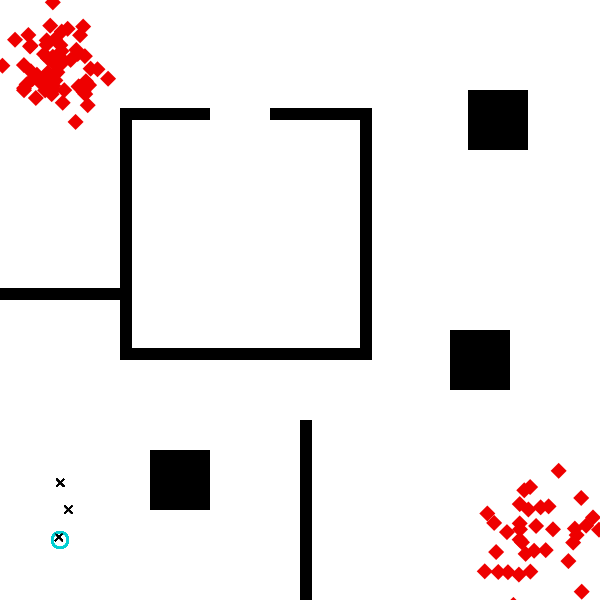

In [37]:
visualize_inference(
    measurements[1:3], scene, start, computation_amt=70, samples=100, num_ticks=3, model=chase_model)

In [38]:
chased_measurements = [
    Point(0.0980245, 0.104775),
    Point(0.148734, 0.150773),
    Point(0.170412, 0.169499),
    Point(0.204794, 0.21000),
    Point(0.2257668, 0.227711),
    Point(0.240181, 0.24304),
    Point(0.274384, 0.276242),
    Point(0.302272, 0.314463),
    Point(0.124597, 0.462056),
    Point(0.126227, 0.498338)];

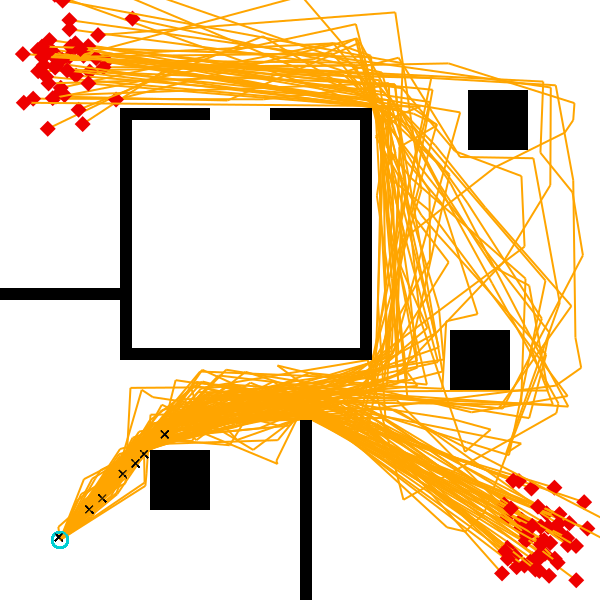

In [39]:
visualize_inference(
    chased_measurements[1:7], scene, start, computation_amt=50, samples=100, draw_path=true, num_ticks=7, model=chase_model)

In [40]:
scene = Scene(xmin=0, xmax=1, ymin=0, ymax=1)
horizontal = false
vertical = true
wall_thickness = 0.02
add_obstacle!(scene, make_line(horizontal, Point(0.20, 0.40), 0.50, wall_thickness));
add_obstacle!(scene, make_line(horizontal, Point(0.20, 0.60), 0.50, wall_thickness));
add_obstacle!(scene, make_line(vertical, Point(0.70, 0.40), 0.05, wall_thickness));
add_obstacle!(scene, make_line(vertical, Point(0.70, 0.57), 0.05, wall_thickness));

add_obstacle!(scene, make_line(vertical, Point(0.20, 0.60), 0.10, wall_thickness));
add_obstacle!(scene, make_line(horizontal, Point(0.20, 0.70), 0.10, wall_thickness));

add_obstacle!(scene, make_line(vertical, Point(0.20, 0.30), 0.10, wall_thickness));
add_obstacle!(scene, make_line(horizontal, Point(0.20, 0.30), 0.10, wall_thickness));


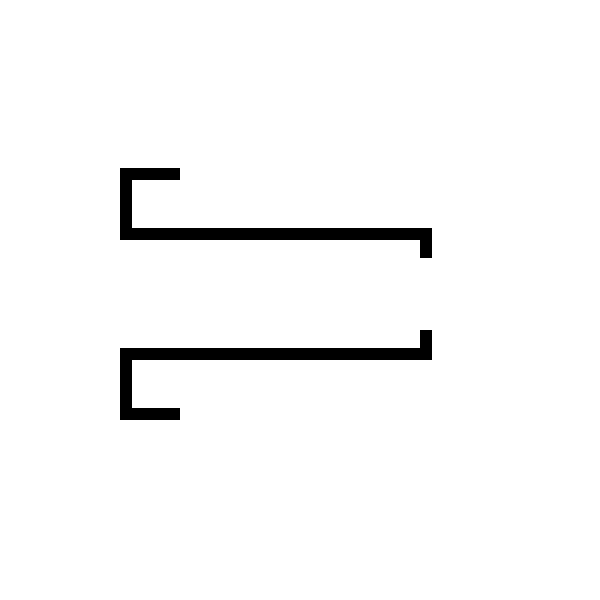

In [88]:
# We visualize the scene below.
visualize() do
    draw_scene(scene)
end

In [42]:
start = Point(0.5, 0.5)
dest = Point(0.5, 0.1)
planner_params = PlannerParams(rrt_iters=600, rrt_dt=3.0,
                               refine_iters=3500, refine_std=1.)
example_path1 = plan_path(start, dest, scene, planner_params)
example_path2 = plan_path(start, dest, scene, planner_params)
example_path3 = plan_path(start, dest, scene, planner_params)

Path(Point[Point(0.5, 0.5), Point(0.4035895860584008, 0.4782086623514734), Point(0.25016841411294066, 0.44467135952435055), Point(0.08901726336382687, 0.39353590484191237), Point(0.27192037176800077, 0.22328075331940456), Point(0.5, 0.1)])

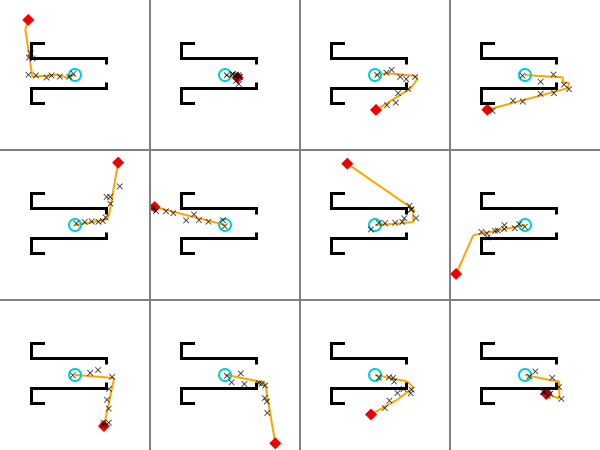

In [43]:
# Let's visualize several traces of the function, with the start location fixed to
# a point in the lower-left corner:
constraints = Gen.choicemap()
constraints[:start_x] = 0.5
constraints[:start_y] = 0.5

traces = [Gen.generate(
    walk_model, (scene, dt, num_ticks, planner_params), constraints
    )[1] for i in 1:12];
visualize_grid(traces, 4, 600; separators="gray") do trace, frame
    draw_trace(trace, frame; draw_measurements=true, markersize=6)
end

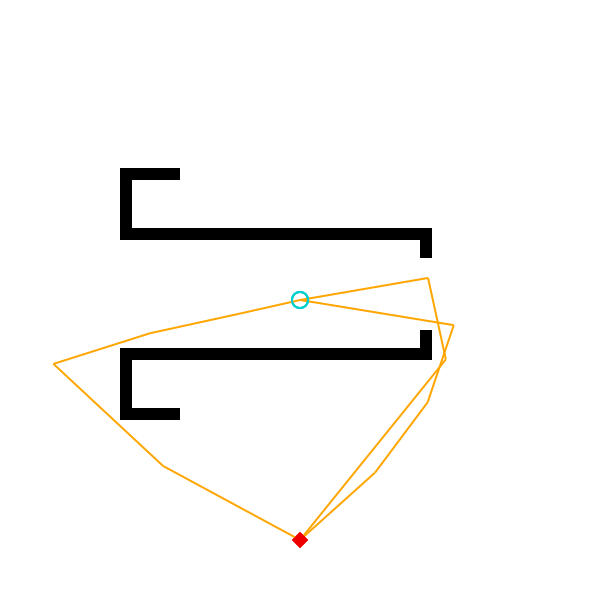

In [44]:
visualize() do
    draw_trace(Dict(:start => start,
                    :dest => dest,
                    :scene => scene,
                    :path => example_path1.points);
               should_draw_measurements=false)
        draw_trace(Dict(:start => start,
                    :dest => dest,
                    :scene => scene,
                    :path => example_path2.points);
               should_draw_measurements=false)
        draw_trace(Dict(:start => start,
                    :dest => dest,
                    :scene => scene,
                    :path => example_path3.points);
               should_draw_measurements=false)
end

In [45]:
@gen function restaurant_model(
        scene::Scene, dt::Float64, num_ticks::Int, 
        planner_params::PlannerParams)

    # sample the start point of the agent from the prior
    start_x ~ uniform(0, 1)
    start_y ~ uniform(0, 1)
    start = Point(start_x, start_y)

    # sample the destination point of the agent from the prior
    restaurant ~ categorical([1/3, 1/3, 1/3])
    dest_xs = [0.25, 0.25, 0.9]
    dest_ys = [0.65, 0.35, 0.9]
    dest_x ~ normal(dest_xs[restaurant], 0.0125)
    dest_y ~ normal(dest_ys[restaurant], 0.0125)
    dest = Point(dest_x, dest_y)

    # plan a path that avoids obstacles in the scene
    maybe_path = plan_path(start, dest, scene, planner_params)
    planning_failed = maybe_path === nothing
    
    # sample the speed from the prior
    speed ~ uniform(0.3, 1)

    if planning_failed   
        # path planning failed; assume agent stays at start location indefinitely
        locations = fill(start, num_ticks)
    else   
        # path planning succeeded; move along the path at constant speed
        locations = walk_path(maybe_path, speed, dt, num_ticks)
    end

    # generate noisy measurements of the agent's location at each time point
    noise = 0.02
    for (i, point) in enumerate(locations)
        x = {:meas => (i, :x)} ~ normal(point.x, noise)
        y = {:meas => (i, :y)} ~ normal(point.y, noise)
    end

    return (planning_failed, maybe_path)
end;

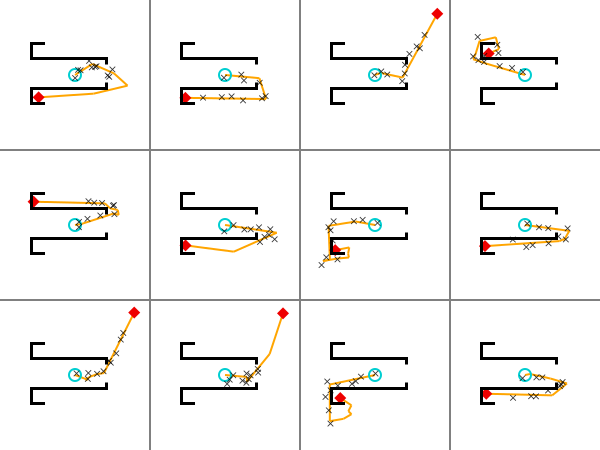

In [46]:
# Let's visualize several traces of the function, with the start location fixed to
# a point in the lower-left corner:
constraints = Gen.choicemap()
constraints[:start_x] = 0.5
constraints[:start_y] = 0.5

traces = [Gen.generate(
    restaurant_model, (scene, dt, num_ticks, planner_params), constraints
    )[1] for i in 1:12];
visualize_grid(traces, 4, 600; separators="gray") do trace, frame
    draw_trace(trace, frame; draw_measurements=true, markersize=6)
end

In [47]:
restaurant_measurements = [
    Point(0.5080245, 0.504775),
    Point(0.60734, 0.50773)];

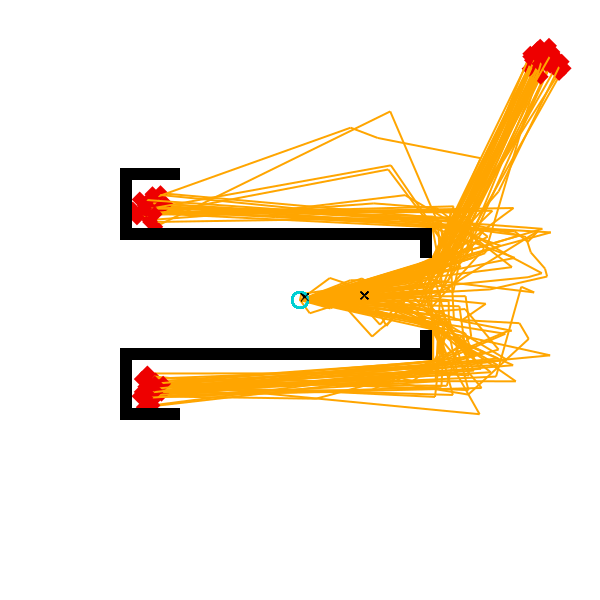

In [48]:
visualize_inference(
    restaurant_measurements, scene, start, computation_amt=50, samples=100, draw_path=true, num_ticks=2, statistics=true, restaurant_visits=restaurant_visits, model=restaurant_model)

In [49]:
restaurant_visits

3-element Vector{Float64}:
 27.0
 36.0
 37.0

In [50]:
restaurant_measurements = [
    Point(0.5080245, 0.504775),
    Point(0.40734, 0.50773)];

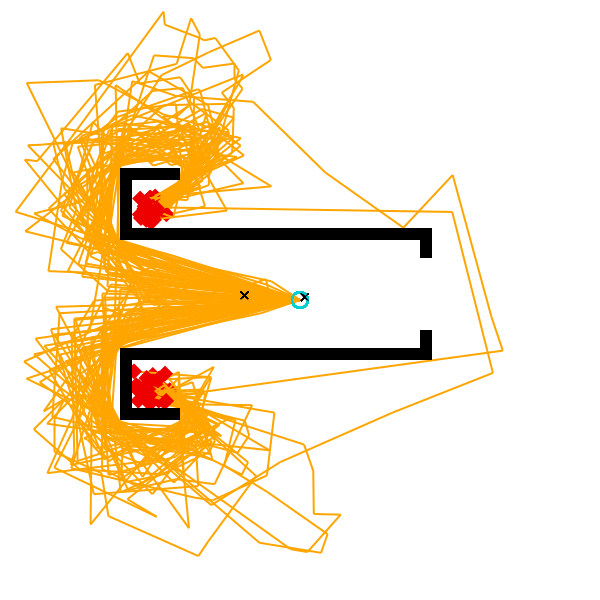

In [51]:
visualize_inference(
    restaurant_measurements, scene, start, computation_amt=50, samples=100, draw_path=true, num_ticks=2, statistics=true, restaurant_visits=restaurant_visits, model=restaurant_model)

In [52]:
restaurant_visits

3-element Vector{Float64}:
 49.0
 51.0
  0.0

## Statistical Analysis

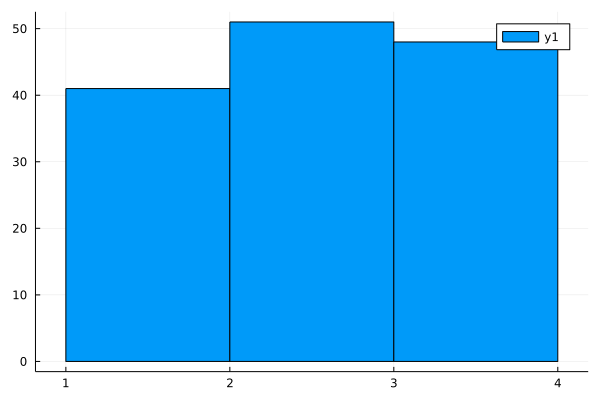

In [53]:
@df data plot(:RestaurantChoice, seriestype=:histogram)

In [54]:
visits = zeros(Int, 3)

for i in 1:3
    visits[i] = sum(data.RestaurantChoice .== i)
end
visits

3-element Vector{Int64}:
 41
 51
 48

In [55]:
@gen function visit_model(prices)
    
    intercept ~ normal(30,30)
    
    price_slope ~ normal(0,15)

    noise ~ gamma(1,1)
    
    
    function f(price)
        return intercept + price * price_slope
    end
    
    for (i,p) in enumerate(prices)
        {(:visits, i)} ~ normal(f(p), noise)
    end
    return f
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any], false, Union{Nothing, Some{Any}}[nothing], var"##visit_model#305", Bool[0], false)

In [56]:
# visits = [30,40,70]

In [57]:
prices = [3., 2.5, 1.]

3-element Vector{Float64}:
 3.0
 2.5
 1.0

In [58]:
test_xs = range(0, 4, length=100)

0.0:0.04040404040404041:4.0

In [59]:
prior_traces = [visit_model([]) for _ in 1:15]

15-element Vector{var"#f#50"{Float64, Float64}}:
 (::var"#f#50"{Float64, Float64}) (generic function with 1 method)
 (::var"#f#50"{Float64, Float64}) (generic function with 1 method)
 (::var"#f#50"{Float64, Float64}) (generic function with 1 method)
 (::var"#f#50"{Float64, Float64}) (generic function with 1 method)
 (::var"#f#50"{Float64, Float64}) (generic function with 1 method)
 (::var"#f#50"{Float64, Float64}) (generic function with 1 method)
 (::var"#f#50"{Float64, Float64}) (generic function with 1 method)
 (::var"#f#50"{Float64, Float64}) (generic function with 1 method)
 (::var"#f#50"{Float64, Float64}) (generic function with 1 method)
 (::var"#f#50"{Float64, Float64}) (generic function with 1 method)
 (::var"#f#50"{Float64, Float64}) (generic function with 1 method)
 (::var"#f#50"{Float64, Float64}) (generic function with 1 method)
 (::var"#f#50"{Float64, Float64}) (generic function with 1 method)
 (::var"#f#50"{Float64, Float64}) (generic function with 1 method)
 (::var"#f#50

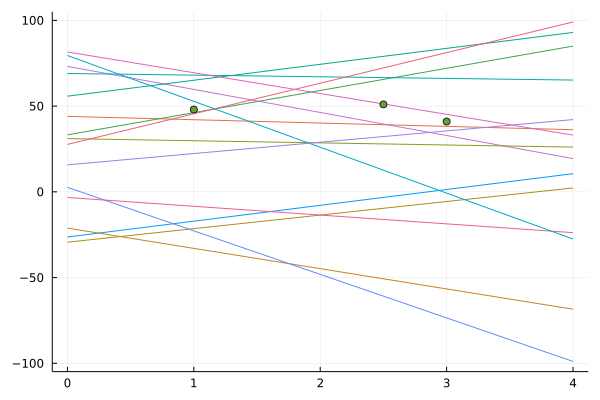

In [60]:
plot(test_xs, [prior_trace.(test_xs) for prior_trace in prior_traces], legend=false)
plot!(prices, visits, seriestype=:scatter)

In [61]:
observations = Gen.choicemap()
for (i,v) in enumerate(visits)
    observations[(:visits, i)] = v
end

traces = [importance_resampling(visit_model,
    (prices,), observations, 50,
    verbose=false)[1] for _ in 1:100]

100-element Vector{Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}}:
 Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any], false, Union{Nothing, Some{Any}}[nothing], var"##visit_model#305", Bool[0], false), Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}(:price_slope => Gen.ChoiceOrCallRecord{Float64}(11.57207326291762, -3.924572911200956, NaN, true), (:visits, 2) => Gen.ChoiceOrCallRecord{Float64}(51.0, -9.018829126772909, NaN, true), :intercept => Gen.ChoiceOrCallRecord{Float64}(6.052988656315339, -4.6387244439193625, NaN, true), (:visits, 3) => Gen.ChoiceOrCallRecord{Float64}(48.0, -26.201556279478613, NaN, true), (:visits, 1) => Gen.ChoiceOrCallRecord{Float64}(41.0, -2.402505105302996, NaN, true), :noise => Gen.ChoiceOrCallRecord{Float64}(4.402588000435441, -4.402588000435441, NaN, true)), Dict{Any, Trie{Any, Gen.ChoiceOrCallRecord}}()), false, -50.58877586711027, 0.0, ([3.0, 2.5, 1.0],), var"#f#5

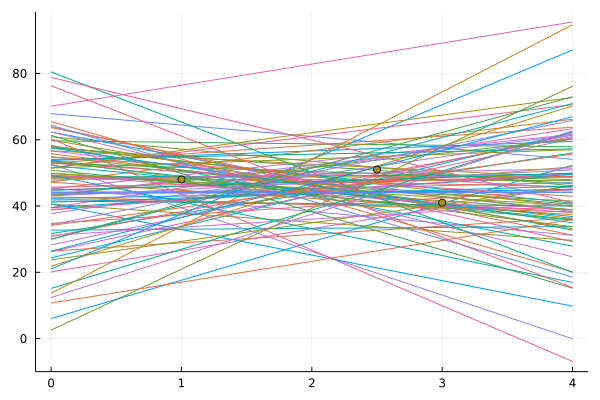

In [62]:
lines = Gen.get_retval.(traces)
plot(test_xs, [f.(test_xs) for f in lines], legend=false)
plot!(prices, visits, seriestype=:scatter)

In [63]:
choices = Gen.get_choices.(traces)
intercepts = Gen.get_value.(choices, :intercept)
price_slopes = Gen.get_value.(choices, :price_slope)
noises = Gen.get_value.(choices, :noise);

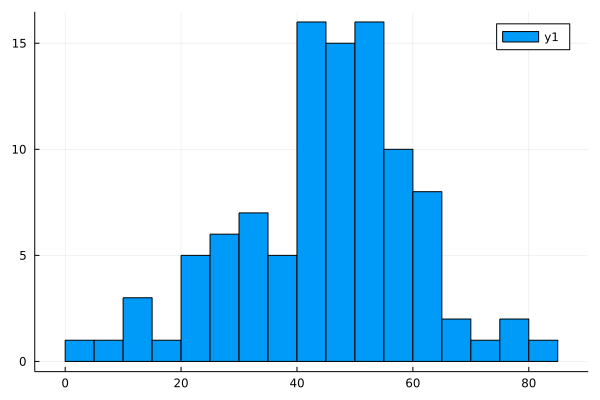

In [64]:
plot(intercepts, bins=25, seriestype=:histogram)

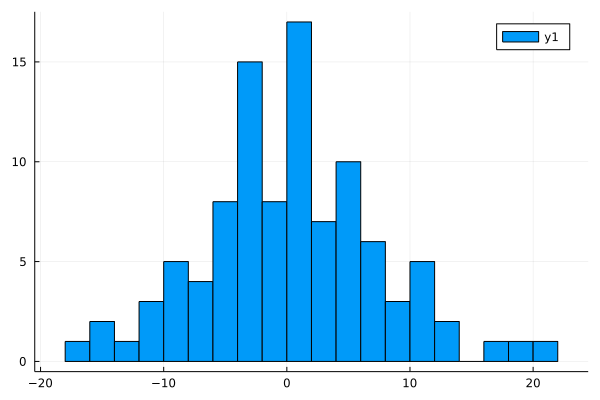

In [65]:
plot(price_slopes, bins=25, seriestype=:histogram)

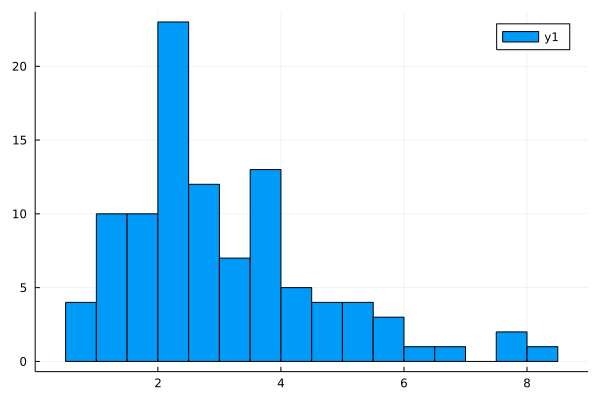

In [66]:
plot(noises, bins=25, seriestype=:histogram)

In [67]:
@gen function visit_full_model(prices, qualities, staff)
    
    intercept ~ normal(30,30)
    
    price_slope ~ normal(0,15)
    quality_slope ~ normal(0,15)
    staff_slope ~ normal(0,15)
    
    noise ~ gamma(1,1)
    
    
    function f(price, quality, staff)
        return intercept + price * price_slope + quality * quality_slope + staff * staff_slope
    end
    
    for (i,p) in enumerate(prices)
        q = qualities[i]
        s = staff[i]
        {(:visits, i)} ~ normal(f(p,q,s), noise)
    end
    return f
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing], var"##visit_full_model#311", Bool[0, 0, 0], false)

In [68]:
qualities = [0.7, 0.5, 0.7]

3-element Vector{Float64}:
 0.7
 0.5
 0.7

In [69]:
staff = [0.5, 0.2, 1.]

3-element Vector{Float64}:
 0.5
 0.2
 1.0

In [70]:
traces = [importance_resampling(visit_full_model,
    (prices, qualities, staff), observations, 50,
    verbose=false)[1] for _ in 1:100]
lines = Gen.get_retval.(traces)

100-element Vector{var"#f#59"{Float64, Float64, Float64, Float64}}:
 (::var"#f#59"{Float64, Float64, Float64, Float64}) (generic function with 1 method)
 (::var"#f#59"{Float64, Float64, Float64, Float64}) (generic function with 1 method)
 (::var"#f#59"{Float64, Float64, Float64, Float64}) (generic function with 1 method)
 (::var"#f#59"{Float64, Float64, Float64, Float64}) (generic function with 1 method)
 (::var"#f#59"{Float64, Float64, Float64, Float64}) (generic function with 1 method)
 (::var"#f#59"{Float64, Float64, Float64, Float64}) (generic function with 1 method)
 (::var"#f#59"{Float64, Float64, Float64, Float64}) (generic function with 1 method)
 (::var"#f#59"{Float64, Float64, Float64, Float64}) (generic function with 1 method)
 (::var"#f#59"{Float64, Float64, Float64, Float64}) (generic function with 1 method)
 (::var"#f#59"{Float64, Float64, Float64, Float64}) (generic function with 1 method)
 (::var"#f#59"{Float64, Float64, Float64, Float64}) (generic function with 1 metho

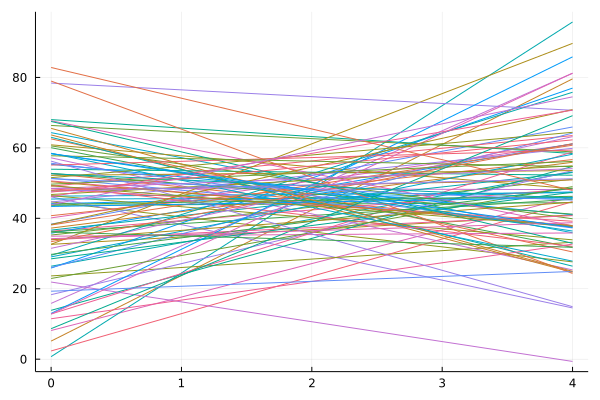

In [71]:
test_xs = range(0, 4, length=100)
plot(test_xs, [f.(test_xs, [0.5 for _ in 1:100], [0.5 for _ in 1:100]) for f in lines], legend=false)

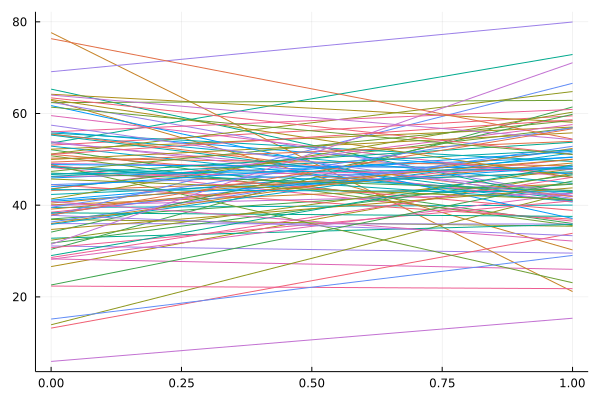

In [72]:
test_xs = range(0,1,length=20)
plot(test_xs, [f.([2 for _ in 1:20], test_xs, [0.5 for _ in 1:20]) for f in lines], legend=false)

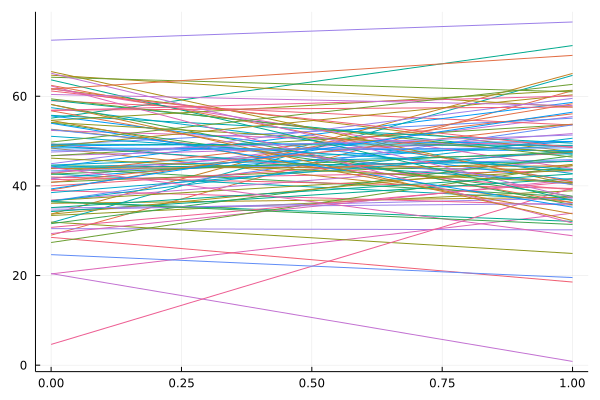

In [73]:
test_xs = range(0,1,length=20)
plot(test_xs, [f.([2 for _ in 1:20], [0.5 for _ in 1:20], test_xs) for f in lines], legend=false)

In [74]:
choices = Gen.get_choices.(traces)
intercepts = Gen.get_value.(choices, :intercept)
price_slopes = Gen.get_value.(choices, :price_slope)
quality_slopes = Gen.get_value.(choices, :quality_slope)
staff_slopes = Gen.get_value.(choices, :staff_slope)
noises = Gen.get_value.(choices, :noise);

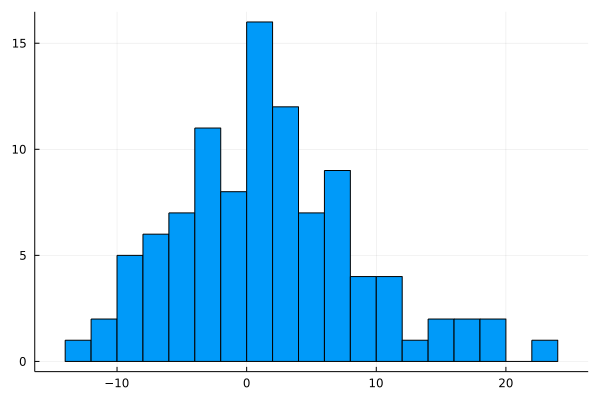

In [75]:
plot(price_slopes, bins=25, seriestype=:histogram, legend=false)

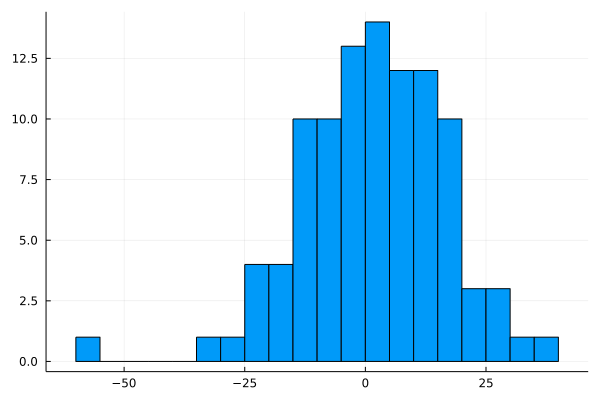

In [76]:
plot(quality_slopes, bins=35, seriestype=:histogram, legend=false)

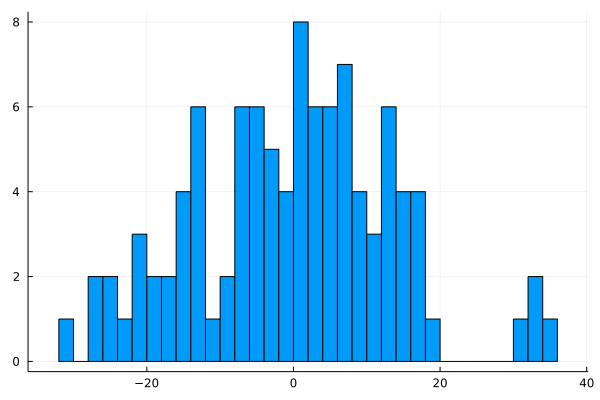

In [77]:
plot(staff_slopes, bins=35, seriestype=:histogram, legend=false)

## Predictive Distribution
https://www.mhnederlof.nl/bayesnormalupdate.html

In [78]:
sample_intercept_mu, sample_intercept_std = mean_and_std(intercepts) 

(41.49050527420906, 21.125470531032068)

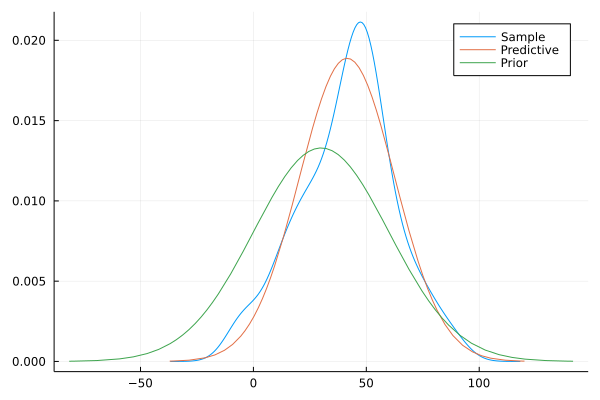

In [79]:
plot(intercepts, seriestype=:density, label="Sample")
plot!(Normal(sample_intercept_mu, sample_intercept_std), label="Predictive")
plot!(Normal(30, 30), label="Prior")

In [80]:
sample_price_slope_mu, sample_price_slope_std = mean_and_std(price_slopes) 

(1.6126500760142162, 7.184924246284228)

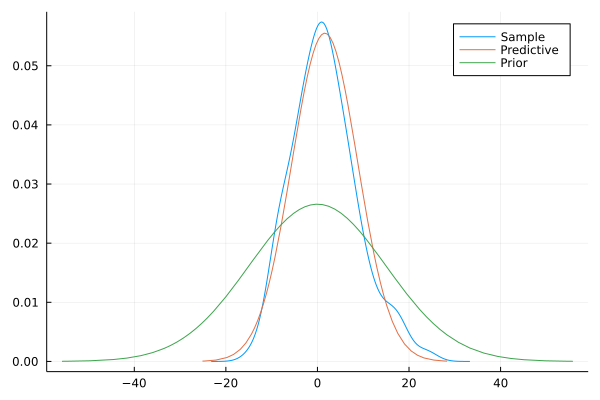

In [81]:
plot(price_slopes, seriestype=:density, label="Sample")
plot!(Normal(sample_price_slope_mu, sample_price_slope_std), label="Predictive")
plot!(Normal(0, 15), label="Prior")

In [82]:
sample_quality_slope_mu, sample_quality_slope_std = mean_and_std(quality_slopes)

(1.8818495164517213, 14.95740865413088)

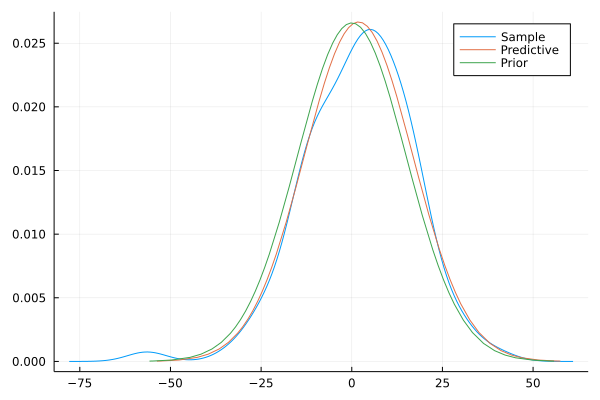

In [83]:
plot(quality_slopes, seriestype=:density, label="Sample")
plot!(Normal(sample_quality_slope_mu, sample_quality_slope_std), label="Predictive")
plot!(Normal(0, 15), label="Prior")

In [84]:
sample_staff_slope_mu, sample_staff_slope_std = mean_and_std(staff_slopes)

(-0.14762126510784482, 13.621121563303923)

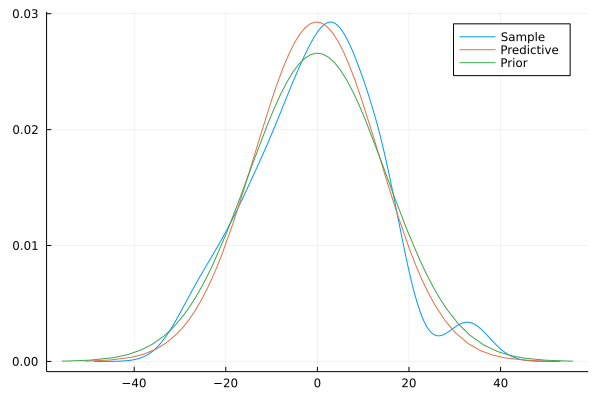

In [85]:
plot(staff_slopes, seriestype=:density, label="Sample")
plot!(Normal(sample_staff_slope_mu, sample_staff_slope_std), label="Predictive")
plot!(Normal(0, 15), label="Prior")

In [86]:
sample_noises_mu, sample_noises_std = mean_and_std(noises)

(2.7696131110254965, 1.305723492291235)

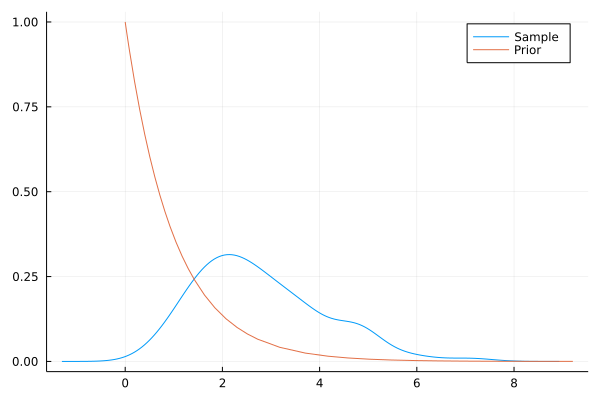

In [87]:
plot(noises, seriestype=:density, label="Sample")
# plot!(Normal(sample_noises_mu, sample_noises_std), label="Predictive")
plot!(Gamma(1, 1), label="Prior")